In [119]:
import pandas as pd
import numpy as np
import re
from connection_keys import connection
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

pd.set_option('display.max_colwidth', None)

In [145]:
connectionbd = connection('db_hardware')
query = """
    select * from graphic_card
"""
df = pd.read_sql(query, connectionbd)

In [146]:
df.dtypes

id                      int64
marca                  object
nome_produto           object
preco_antigo_cartao    object
preco_atual_cartao     object
preco_boleto           object
data                   object
hora                   object
loja                   object
disponibilidade        object
dtype: object

In [147]:
df.sample(10)

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
182,183,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1060 Windforce 3G, 3GB, GDDR5 - GV-N1060WF2-3GD","2.282,24","1.994,00","1.694,90",2020-09-10,19:12:39,Kabum,Disponivel
160,161,Evga,"Placa de Vídeo EVGA NVIDIA GeForce RTX 2070 Super FTW3 Ultra+ Overclocked, 8GB, GDDR6 - 08G-P4-3377-KR","5.555,18","4.705,76","3.999,90",2020-09-10,19:12:39,Kabum,Disponivel
49,50,ASRock,"Placa de Video Asrock Phantom Gaming D Radeon RX570 8G OC, GDDR5",0,"1.764,59","1.499,90",2020-09-10,19:12:39,Kabum,Disponivel
264,265,Evga,Placa de Vídeo VGA NVIDIA EVGA GEFORCE GT 9800 1GB DDR3 256 bits PCI-E 2.0 01G-P3-N988-TR,0,"445,76","378,90",2020-09-10,19:12:39,Kabum,Indisponivel
265,266,Evga,Placa de vídeo VGA EVGA GeForce GTX650Ti Boost 2GB 192-Bit GDDR5 PCI-Express 3.0 SLI Support - 02G-P4-3657-KR,0,"874,90","743,66",2020-09-10,19:12:39,Kabum,Indisponivel
115,116,Sapphire,"Placa de Vídeo Sapphire Nitro+ AMD Radeon RX 5500 XT, 8GB, GDDR6 Special Edition - 11295-05-20G",0,"2.352,82","1.999,90",2020-09-10,19:12:39,Kabum,Disponivel
338,339,Sapphire,"Placa de Vídeo Sapphire AMD Radeon RX 590, 8GB, GDDR5 - 11289-01-20G",0,"1.411,65","1.199,90",2020-09-10,19:12:39,Kabum,Indisponivel
284,285,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1060 Gaming 6GB, GDDR5 - 06G-P4-6161-KR","1.176,35","941,06","799,90",2020-09-10,19:12:39,Kabum,Indisponivel
22,23,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1650 OC 4G, GDDR5 - GV-N1650OC-4GD",0,"1.705,76","1.449,90",2020-09-10,19:12:39,Kabum,Disponivel
294,295,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1050 SSC Gaming 2GB, GDDR5 - 02G-P4-6152-KR",0,"705,76","599,90",2020-09-10,19:12:39,Kabum,Indisponivel


In [148]:
df['preco_antigo_cartao'] = df['preco_antigo_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_atual_cartao'] = df['preco_atual_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_boleto'] = df['preco_boleto'].str.replace('.', '').str.replace(',', '.').astype(float)

In [149]:
df_marcas = df['preco_atual_cartao'].groupby(df['marca'])
print(df_marcas.mean())

marca
ASRock        2251.466154
Afox           403.817500
Amd           5921.450000
Aorus         9212.824000
Asus          3014.610909
Colorful      4827.015000
Deepcool       105.760000
Evga          3532.414386
Gainward      5177.025714
Galax         3394.831333
Gigabyte      2789.038837
Husky          823.410000
Liketec         23.410000
MSI           2591.216829
PCYes          525.448889
Pny           4053.407273
Powercolor    1691.156667
Rise Mode       36.468235
Sapphire      2182.926000
XFX           2049.386154
Zotac         2312.142800
Name: preco_atual_cartao, dtype: float64


In [150]:
df[df['marca'] == 'Asus']

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
1,2,Asus,"Placa de Vídeo Asus TUF NVIDIA GeForce RTX 2060 6GB, GDDR6 - TUF-RTX2060-O6G-GAMING",2894.00,2658.71,2259.90,2020-09-10,19:12:39,Kabum,Disponivel
2,3,Asus,"Placa de Vídeo Asus TUF3 NVIDIA GeForce GTX 1660 SUPER 6GB, GDDR6 - TUF 3-GTX1660S-O6G-GAMING",2420.95,1894.63,1799.90,2020-09-10,19:12:39,Kabum,Disponivel
31,32,Asus,"Placa de Vídeo Asus TUF NVIDIA GeForce RTX 2060 6GB, GDDR6 - TUF-RTX2060-O6G-GAMING",2894.00,2658.71,2259.90,2020-09-10,19:12:39,Kabum,Disponivel
32,33,Asus,"Placa de Vídeo Asus TUF3 NVIDIA GeForce GTX 1660 SUPER 6GB, GDDR6 - TUF 3-GTX1660S-O6G-GAMING",2420.95,1894.63,1799.90,2020-09-10,19:12:39,Kabum,Disponivel
88,89,Asus,"Placa de Vídeo Asus NVIDIA Dual GeForce RTX 2080 Super EVO V2 OC, 8GB, GDDR6 - DUAL-RTX2080S-O8G-EVO-V2",5882.24,5411.65,4599.90,2020-09-10,19:12:39,Kabum,Disponivel
94,95,Asus,"Placa de Vídeo Asus Dual AMD Radeon RX 5500 XT EVO, 4GB, GDDR6 - DUAL-RX5500XT-O4G-EVO",1884.59,1823.41,1549.90,2020-09-10,19:12:39,Kabum,Disponivel
105,106,Asus,"Placa de Vídeo Asus Dual NVIDIA GeForce RTX 2080 Super EVO, 8GB, GDDR6 - DUAL-RTX2080S-8G-EVO-V2",0.00,6235.18,5299.90,2020-09-10,19:12:39,Kabum,Disponivel
110,111,Asus,Case para Placa de Vídeo Asus ROG XG Station 2 - 90YV09B1-M0SA00,5170.47,4258.71,3619.90,2020-09-10,19:12:39,Kabum,Disponivel
125,126,Asus,"Placa de Vídeo Asus ROG Strix NVIDIA GeForce RTX 2080 Ti 11GB, GDDR6 - ROG-STRIX-RTX2080TI-O11G-GAMING",0.00,11058.71,9399.90,2020-09-10,19:12:39,Kabum,Disponivel
149,150,Asus,"Placa de Vídeo Asus Rog Strix NVIDIA GeForce RTX 2080 Super White Edition, 8GB, GDDR6 - ROG-STRIX-RTX2080S-O8G-WHITE-GAMING",0.00,7294.00,6199.90,2020-09-10,19:12:39,Kabum,Disponivel


In [151]:
df.query('nome_produto.str.contains("GTX 1660") & (~nome_produto.str.contains("Ti") & ~nome_produto.str.contains("Super") & ~nome_produto.str.contains("SUPER"))')

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
12,13,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-10,19:12:39,Kabum,Disponivel
42,43,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1660 OC 6G, GDDR5 - GV-N1660OC-6GD",2157.79,2052.53,1949.9,2020-09-10,19:12:39,Kabum,Disponivel
163,164,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1660 XC Gaming 6GB, GDDR5 - 06G-P4-1163-KR",2117.53,1941.06,1649.9,2020-09-10,19:12:39,Kabum,Disponivel
173,174,Zotac,"Placa de Vídeo Zotac Gaming NVIDIA GeForce GTX 1660 Twin Fan, 6GB, GDDR5 - ZT-T16600K-10M",0.00,2352.82,1999.9,2020-09-10,19:12:39,Kabum,Disponivel
329,330,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1660 XC Black Gaming 6GB, GDDR5 - 06G-P4-1161-KR",0.00,2082.24,1769.9,2020-09-10,19:12:39,Kabum,Indisponivel
330,331,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1660 XC Ultra Gaming 6GB, GDDR5 - 06G-P4-1167-KR",0.00,1882.24,1599.9,2020-09-10,19:12:39,Kabum,Indisponivel
332,333,Galax,"Placa de Vídeo Galax NVIDIA GeForce GTX 1660 1-Click OC, 6GB, GDDR5 - 60SRH7DSY91C",2235.18,2199.88,1869.9,2020-09-10,19:12:39,Kabum,Indisponivel
336,337,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1660 SC Ultra Gaming 6GB, GDDR5 - 06G-P4-1067-KR",2235.18,2011.65,1709.9,2020-09-10,19:12:39,Kabum,Indisponivel
373,374,Evga,"Placa de Vídeo EVGA NVIDIA GeForce GTX 1660 Black Gaming, 6GB, GDDR5 - 06G-P4-1160-KR",2352.82,2117.53,1799.9,2020-09-10,19:12:39,Kabum,Indisponivel


In [152]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)(\d+)"
    resume_name = re.search(pattern, name.replace(" ", ""))
    if resume_name is None: 
        return '' 
    else: 
        return resume_name.group()

df['nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['nome_produto']), axis=1)

In [156]:
len(df.query('nome_produto_resumido == ""').index)

28

In [74]:
indexNames = df[df['nome_produto_resumido'] == '' ].index
df.drop(indexNames , inplace=True)

In [131]:
placa = 'GTX 1660'
analise = df.query(f'nome_produto.str.contains("{placa}")')
(analise['preco_atual_cartao'].groupby(analise['marca']).mean())

marca
Evga        2030.473333
Galax       2199.880000
Gigabyte    2052.530000
Zotac       2352.820000
Name: preco_atual_cartao, dtype: float64

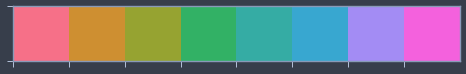

In [82]:
sns.palplot(sns.color_palette("husl", 8))

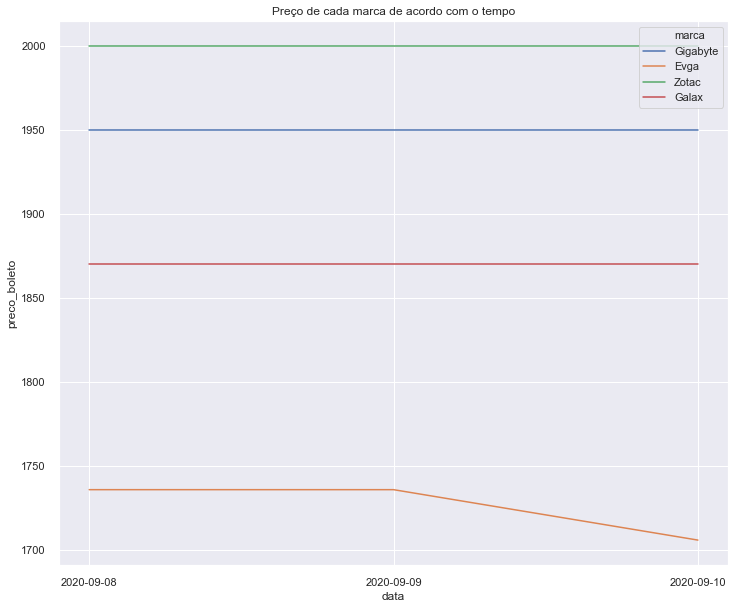

In [132]:
# plt.figure(figsize=(30,19))
sns.set(rc={'figure.figsize':(12,10)})
ax = sns.lineplot(
    x="data",
    y="preco_boleto",
    hue='marca',
    data=analise,
    ci=None,
    markers=True
).set_title('Preço de cada marca de acordo com o tempo');